- 개발 환경(OS): Windows 10, 64비트 운영 체제, x64 기반 프로세서

### 라이브러리 버전 

In [1]:
import sys
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import xgboost
import catboost
print("-------------------------- Python & library version --------------------------")
print("Python version: {}".format(sys.version))
print("numpy version: {}".format(np.__version__))
print("pandas version: {}".format(pd.__version__))
print("matplotlib version: {}".format(matplotlib.__version__))
print("xgboost version: {}".format(xgboost.__version__))
print("catboost version: {}".format(catboost.__version__))
print("------------------------------------------------------------------------------")

-------------------------- Python & library version --------------------------
Python version: 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.20.1
pandas version: 1.2.4
matplotlib version: 3.3.4
xgboost version: 1.4.2
catboost version: 0.26.1
------------------------------------------------------------------------------


### 라이브러리 로드

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### 경로 설정 및 데이터 로드

In [3]:
#경로 설정
root_dir = Path('../NH/')
data_dir = Path('../NH/data/')

stk_hld_train = data_dir / 'stk_hld_train.csv'
stk_hld_test = data_dir / 'stk_hld_test.csv'
stk_bnc_hist = data_dir / 'stk_bnc_hist.csv'
iem_info = data_dir / 'iem_info_20210902.csv'
cus_info = data_dir / 'cus_info.csv'

sample_submission = data_dir / 'sample_submission.csv'

In [4]:
trn = pd.read_csv(stk_hld_train)
tst = pd.read_csv(stk_hld_test)
hist = pd.read_csv(stk_bnc_hist)
iem = pd.read_csv(iem_info)
cus = pd.read_csv(cus_info)
sub = pd.read_csv(sample_submission)

### Feature 병합

In [5]:
trn = pd.merge(trn, cus, how = "left", on = ["act_id"])
trn = pd.merge(trn, iem, how = "left", on = ["iem_cd"])
trn = pd.merge(trn, hist, how = "left", on = ["act_id", "iem_cd"])
trn = trn[(trn["byn_dt"] == trn["bse_dt"])]
trn.reset_index(drop = True, inplace = True)


tst = pd.merge(tst, cus, how = "left", on = ["act_id"])
tst = pd.merge(tst, iem, how = "left", on = ["iem_cd"])
tst = pd.merge(tst, hist, how = "left", on = ["act_id", "iem_cd"])
tst = tst[(tst["byn_dt"] == tst["bse_dt"])]
tst.reset_index(drop = True, inplace = True)

### 데이터셋 분할

In [6]:
# 2020년 12월 1일 ~ 2020년 12월 31일 사이에 매수
tst_1 = tst[tst['hist_d'] < 22]
trn_1 = trn[(trn['hold_d'] > 1) & (trn['hold_d'] < 168)]

# 2020년 8월 11일 ~ 2020년 11월 30일 사이에 매수
tst_2 = tst[(tst['hist_d'] > 21) & (tst['hist_d'] < 97)]
trn_2 = trn[(trn['hold_d'] > 22) & (trn['hold_d'] < 242)]

# 2016년 1월 4일 ~ 2020년 8월 10일 사이에 매수
tst_3 = tst[tst['hist_d'] > 96]
trn_3 = trn[trn['hold_d'] >97]

### PreProcessing
<h4>Feature Engineering : Train Data 1 

In [7]:
# trn_1

# 성별 => [2] -> 원본 유지
# age => [1,2,7,8] -> 1, [3,4,5,6] -> 2, [9] -> 3, onehot
# ivs_icn_cd => [5,9] ->  1 그 외 0
# cus_aet_stn_cd => [1,2,3,4] -> 1 그 외 0
# mrz_pdt_tp_sgm_cd => drop 
# lsg_sgm_cd => [9] -> 1, [2,3,5,6,7,8] -> 2, [4] -> 3, onehot
# tco_cus_grd_cd => [99] -> 1, [5] -> 2, [1,3,4,9] -> 3, [2] -> 4 onehot
# tot_ivs_te_sgm_cd => [1,2,6] -> 1 그 외 0
# mrz_btp_dit_cd => model 그대로
# btp_cfc_cd => model 그대로
# mkt_pr_tal_scl_tp_cd => [2,3] -> 1, 그 외 0
# stk_dit_cd => [1] -> 1, 그 외 0

In [8]:
#######################################################
### """sex_dit_cd"""
### 원본 사용


#######################################################
### """cus_age_stn_cd"""

def age_func(x):
    if x in [1,2,7,8]:
        return 1
    
    elif x in [3,4,5,6]:
        return 2
    
    else:
        return 3
    
    
trn_1 = pd.concat([trn_1, pd.get_dummies((trn_1['cus_age_stn_cd'].apply(age_func)), prefix='cus_age')],axis=1)
tst_1 = pd.concat([tst_1, pd.get_dummies((tst_1['cus_age_stn_cd'].apply(age_func)), prefix='cus_age')],axis=1)
trn_1 = trn_1.drop(['cus_age_stn_cd'],axis=1)
tst_1 = tst_1.drop(['cus_age_stn_cd'],axis=1)


#######################################################
### """ivs_icn_cd"""

def ivs_func(x):
    if x in [5,9]:
        return 1
    else:
        return 0

trn_1['ivs_icn'] = trn_1['ivs_icn_cd'].apply(ivs_func)
tst_1['ivs_icn'] = tst_1['ivs_icn_cd'].apply(ivs_func)
trn_1 = trn_1.drop(['ivs_icn_cd'],axis=1)
tst_1 = tst_1.drop(['ivs_icn_cd'],axis=1)


#######################################################    
### """cus_aet_stn_cd"""

def cus_aet_func(x):
    if x in [1,2,3,4]:
        return 1
    else:
        return 0 
    
trn_1['cus_aet'] = trn_1['cus_aet_stn_cd'].apply(cus_aet_func)
tst_1['cus_aet'] = tst_1['cus_aet_stn_cd'].apply(cus_aet_func)
trn_1 = trn_1.drop(['cus_aet_stn_cd'],axis=1)
tst_1 = tst_1.drop(['cus_aet_stn_cd'],axis=1)


#######################################################
### """mrz_pdt_tp_sgm_cd"""

trn_1 = trn_1.drop(['mrz_pdt_tp_sgm_cd'],axis=1)
tst_1 = tst_1.drop(['mrz_pdt_tp_sgm_cd'],axis=1)


#######################################################
### """lsg_sgm_cd"""

def lsg_sgm_func(x):
    if x in [9]:
        return 1
    
    elif x in [2,3,5,6,7,8]:
        return 2
  
    else:
        return 3
    
    
trn_1 = pd.concat([trn_1, pd.get_dummies((trn_1['lsg_sgm_cd'].apply(lsg_sgm_func)), prefix='lsg_sgm')],axis=1)
tst_1 = pd.concat([tst_1, pd.get_dummies((tst_1['lsg_sgm_cd'].apply(lsg_sgm_func)), prefix='lsg_sgm')],axis=1)
trn_1 = trn_1.drop(['lsg_sgm_cd'],axis=1)
tst_1 = tst_1.drop(['lsg_sgm_cd'],axis=1)


#######################################################
### """tco_cus_grd_cd"""

def cus_grd_func(x):
    if x in [99]:
        return 1
    
    elif x in [5]:
        return 2
    
    elif x in [1,3,4,9]:
        return 3
  
    else:
        return 4
    
    
trn_1 = pd.concat([trn_1, pd.get_dummies((trn_1['tco_cus_grd_cd'].apply(cus_grd_func)), prefix='cus_grd')],axis=1)
tst_1 = pd.concat([tst_1, pd.get_dummies((tst_1['tco_cus_grd_cd'].apply(cus_grd_func)), prefix='cus_grd')],axis=1)
trn_1 = trn_1.drop(['tco_cus_grd_cd'],axis=1)
tst_1 = tst_1.drop(['tco_cus_grd_cd'],axis=1)


#######################################################
### """tot_ivs_te_sgm_cd"""

def tot_ivs_func(x):
    if x in [1,2,6]:
        return 1
    else:
        return 0 
    
trn_1['tot_ivs'] = trn_1['tot_ivs_te_sgm_cd'].apply(tot_ivs_func)
tst_1['tot_ivs'] = tst_1['tot_ivs_te_sgm_cd'].apply(tot_ivs_func)
trn_1 = trn_1.drop(['tot_ivs_te_sgm_cd'],axis=1)
tst_1 = tst_1.drop(['tot_ivs_te_sgm_cd'],axis=1)


#######################################################
### """mrz_btp_dit_cd"""

btp_dit_mean = trn_1.groupby(['mrz_btp_dit_cd'])['hold_d'].mean()
btp_dit_median = trn_1.groupby(['mrz_btp_dit_cd'])['hold_d'].median()
btp_dit = pd.concat([btp_dit_mean,btp_dit_median],axis=1)

kmeans1 = KMeans(n_clusters=4, random_state = 2)
km_cluster1 = kmeans1.fit_predict(btp_dit)
btp_dit_cluster = dict(zip(list(range(1,17)), km_cluster1))

trn_1 = pd.concat([trn_1,pd.get_dummies(trn_1['mrz_btp_dit_cd'].map(btp_dit_cluster), prefix='btp_dit')], axis=1)
tst_1 = pd.concat([tst_1,pd.get_dummies(tst_1['mrz_btp_dit_cd'].map(btp_dit_cluster), prefix='btp_dit')], axis=1)
trn_1 = trn_1.drop(['mrz_btp_dit_cd'],axis=1)
tst_1 = tst_1.drop(['mrz_btp_dit_cd'],axis=1)


#######################################################
### """btp_cfc_cd"""

btp_cfc_mean = trn_1.groupby(['btp_cfc_cd'])['hold_d'].mean()
btp_cfc_median = trn_1.groupby(['btp_cfc_cd'])['hold_d'].median()
btp_cfc = pd.concat([btp_cfc_mean,btp_cfc_median],axis=1)

kmeans2 = KMeans(n_clusters=4, random_state = 2)
km_cluster2 = kmeans2.fit_predict(btp_cfc)
btp_cfc_cluster = dict(zip(list(range(1,15)), km_cluster2))

trn_1 = pd.concat([trn_1,pd.get_dummies(trn_1['btp_cfc_cd'].map(btp_cfc_cluster), prefix='btp_cfc')], axis=1)
tst_1 = pd.concat([tst_1,pd.get_dummies(tst_1['btp_cfc_cd'].map(btp_cfc_cluster), prefix='btp_cfc')], axis=1)
trn_1 = trn_1.drop(['btp_cfc_cd'],axis=1)
tst_1 = tst_1.drop(['btp_cfc_cd'],axis=1)


#######################################################
### """mkt_pr_tal_scl_tp_cd"""

def mkt_cap_func(x):
    if x in [2,3]:
        return 1
    
    else:
        return 0
    
trn_1['mkt_cap'] = trn_1['mkt_pr_tal_scl_tp_cd'].apply(mkt_cap_func)
tst_1['mkt_cap'] = tst_1['mkt_pr_tal_scl_tp_cd'].apply(mkt_cap_func)
trn_1 = trn_1.drop(['mkt_pr_tal_scl_tp_cd'],axis=1)
tst_1 = tst_1.drop(['mkt_pr_tal_scl_tp_cd'],axis=1)


#######################################################
### """stk_dit_cd"""

def stk_dit_func(x):
    if x in [1]:
        return 1
    
    else:
        return 0
    
trn_1['stk_dit'] = trn_1['stk_dit_cd'].apply(stk_dit_func)
tst_1['stk_dit'] = tst_1['stk_dit_cd'].apply(stk_dit_func)
trn_1 = trn_1.drop(['stk_dit_cd'],axis=1)
tst_1 = tst_1.drop(['stk_dit_cd'],axis=1)






#######################################################
### Add New Features
#######################################################



#######################################################
### """aet_qty"""
### 잔고금액 / 잔고 수량

trn_1["aet_qty"] = trn_1["tot_aet_amt"] / trn_1["bnc_qty"]
tst_1["aet_qty"] = tst_1["tot_aet_amt"] / tst_1["bnc_qty"]
trn_1["aet_qty"] = trn_1["aet_qty"].apply(np.log1p)
tst_1["aet_qty"] = tst_1["aet_qty"].apply(np.log1p)


#######################################################
### """user_char""" 
### 유저별 거래 특성: 보유 기간이 단기적인지 장기적인지

user_mean = trn_1.groupby(['act_id'])['hold_d'].mean().reset_index()
user_median = trn_1.groupby(['act_id'])['hold_d'].median().reset_index()
user_hold = pd.merge(user_mean, user_median, how='left', on=['act_id'])

kmeans3 = KMeans(n_clusters=4, random_state = 2)
km_cluster3 = kmeans3.fit_predict(user_hold.iloc[:,1:3])

user_hold['user_hold'] = km_cluster3
user_hold.drop(['hold_d_x','hold_d_y'], axis=1, inplace=True)

trn_1 = pd.merge(trn_1, user_hold, how='left', on=['act_id'])
tst_1 = pd.merge(tst_1, user_hold, how='left', on=['act_id'])

trn_1 = pd.concat([trn_1,pd.get_dummies(trn_1['user_hold'], prefix='user_hold')], axis=1)
tst_1 = pd.concat([tst_1,pd.get_dummies(tst_1['user_hold'], prefix='user_hold')], axis=1)

trn_1 = trn_1.drop(['user_hold'],axis=1)
tst_1 = tst_1.drop(['user_hold'],axis=1)


#######################################################
### """num_tra""" 
### 유저별로 거래한 횟수

user_size = trn_1.groupby(['act_id']).size().reset_index()
user_size.rename(columns = {0 : 'user_size'},inplace=True)

# 유저별 거래 횟수에 극단적인 값들이 포합되어 있어, MinMaxScale이 아닌 robust scaling을 해줌.
scaler_X = np.array(user_size['user_size']).reshape(-1,1)
feature_robustscaler = RobustScaler()
feature_robustscaler.fit(scaler_X)
X_scaled = feature_robustscaler.transform(scaler_X)
user_size['user_size'] = X_scaled

trn_1 = pd.merge(trn_1, user_size, how='left', on=['act_id'])
tst_1 = pd.merge(tst_1, user_size, how='left', on=['act_id'])


#######################################################
#######################################################
### 외부 데이터
#######################################################
#######################################################

### 코스피 지수, 코스피200 지수(공포 지수) 사용
### https://kr.investing.com/indices/kospi-200
### https://kr.investing.com/indices/kospi
### 위의 링크(인베스팅닷컴)에서 데이터 추출 가능.

# 데이터 불러오기
kospi_index = data_dir / 'KOSPI.csv'
kospi200_index = data_dir / 'KOSPI200.csv'

kospi = pd.read_csv(kospi_index)
kospi200 = pd.read_csv(kospi200_index)


def str_to_int(x):
    return int(x[:4]+x[6:8]+x[10:12])

def change_type(i):
    return float(i[:-1])

kospi = kospi[['날짜','변동 %']]
kospi200 = kospi200[['날짜','변동 %']]

kospi.columns = ['byn_dt','KOSPI_vix']
kospi200.columns = ['byn_dt','KOSPI200_vix']

kospi['byn_dt'] = kospi['byn_dt'].apply(str_to_int)
kospi200['byn_dt'] = kospi200['byn_dt'].apply(str_to_int)
kospi['KOSPI_vix'] = kospi['KOSPI_vix'].apply(change_type)
kospi200['KOSPI200_vix'] = kospi200['KOSPI200_vix'].apply(change_type)

# Add KOSPI vix
trn_1 = pd.merge(trn_1, kospi, how = 'left', on = ['byn_dt'])
tst_1 = pd.merge(tst_1, kospi, how = 'left', on = ['byn_dt'])

# Add KOSPI200 vix
trn_1 = pd.merge(trn_1, kospi200, how = 'left', on = ['byn_dt'])
tst_1 = pd.merge(tst_1, kospi200, how = 'left', on = ['byn_dt'])

####################################################### drop unnecessary data
trn_1 = trn_1.drop(['act_id', 'iem_cd', 'byn_dt', 'bse_dt', 'iem_krl_nm', 
                    'bnc_qty','tot_aet_amt','stk_par_pr'],axis=1)
tst_1 = tst_1.drop(['act_id', 'iem_cd', 'byn_dt', 'bse_dt', 'iem_krl_nm',
                    'bnc_qty','tot_aet_amt','stk_par_pr'],axis=1)

<h4>Feature Engineering : Train Data 2 

In [9]:
# trn_2

# 성별 => drop
# age => model 그대로
# ivs_icn_cd => [0,5] -> 1 그 외 0
# cus_aet_stn_cd => [1,3,4] -> 1 그 외 0
# mrz_pdt_tp_sgm_cd => drop 
# lsg_sgm_cd => [9] -> 1, [2,3,7,8] -> 2, 그 외 3 onehot
# tco_cus_grd_cd => [99] -> 1, [3,4,5,9] ->2, 그 외 -> 3 onehot
# tot_ivs_te_sgm_cd => [1,2]->1, [3,6]->2, 그 외 3 onehot
# mrz_btp_dit_cd => model 그대로
# btp_cfc_cd => model 그대로
# mkt_pr_tal_scl_tp_cd => [1,2] -> 1, 그 외 0
# stk_dit_cd => 바로 onehot

In [10]:
#######################################################
### """sex_dit_cd"""
### drop

trn_2 = trn_2.drop(['sex_dit_cd'],axis=1)
tst_2 = tst_2.drop(['sex_dit_cd'],axis=1)


#######################################################
### """cus_age_stn_cd"""

def age_func_2(x):
    # 20대
    if 0 < x < 3:
        return 0
    # 30대
    elif 2 < x < 5:
        return 1
    # 40대
    elif 4 < x < 7:
        return 2
    # 50대
    elif 6 < x < 9:
        return 3
    # 60대
    else:
        return 4
    
trn_2['cus_age'] = trn_2['cus_age_stn_cd'].apply(age_func_2)
tst_2['cus_age'] = tst_2['cus_age_stn_cd'].apply(age_func_2)
    
trn_2 = trn_2.drop(['cus_age_stn_cd'],axis=1)
tst_2 = tst_2.drop(['cus_age_stn_cd'],axis=1)


#######################################################
### """ivs_icn_cd"""

def ivs_func_2(x):
    if x in [0,5]:
        return 1
    else:
        return 0

trn_2['ivs_icn'] = trn_2['ivs_icn_cd'].apply(ivs_func_2)
tst_2['ivs_icn'] = tst_2['ivs_icn_cd'].apply(ivs_func_2)
trn_2 = trn_2.drop(['ivs_icn_cd'],axis=1)
tst_2 = tst_2.drop(['ivs_icn_cd'],axis=1)


#######################################################    
### """cus_aet_stn_cd"""

def cus_aet_func_2(x):
    if x in [1,3,4]:
        return 1
    else:
        return 0 
    
trn_2['cus_aet'] = trn_2['cus_aet_stn_cd'].apply(cus_aet_func_2)
tst_2['cus_aet'] = tst_2['cus_aet_stn_cd'].apply(cus_aet_func_2)
trn_2 = trn_2.drop(['cus_aet_stn_cd'],axis=1)
tst_2 = tst_2.drop(['cus_aet_stn_cd'],axis=1)


#######################################################
### """mrz_pdt_tp_sgm_cd"""

trn_2 = trn_2.drop(['mrz_pdt_tp_sgm_cd'],axis=1)
tst_2 = tst_2.drop(['mrz_pdt_tp_sgm_cd'],axis=1)


#######################################################
### """lsg_sgm_cd"""

def lsg_sgm_func_2(x):
    if x in [9]:
        return 1
    
    elif x in [2,3,7,8]:
        return 2
  
    else:
        return 3
    
    
trn_2 = pd.concat([trn_2, pd.get_dummies((trn_2['lsg_sgm_cd'].apply(lsg_sgm_func_2)), prefix='lsg_sgm')],axis=1)
tst_2 = pd.concat([tst_2, pd.get_dummies((tst_2['lsg_sgm_cd'].apply(lsg_sgm_func_2)), prefix='lsg_sgm')],axis=1)
trn_2 = trn_2.drop(['lsg_sgm_cd'],axis=1)
tst_2 = tst_2.drop(['lsg_sgm_cd'],axis=1)


#######################################################
### """tco_cus_grd_cd"""

def cus_grd_func_2(x):
    if x in [99]:
        return 1
    
    elif x in [3,4,5,9]:
        return 2
    
    else:
        return 3
    
    
trn_2 = pd.concat([trn_2, pd.get_dummies((trn_2['tco_cus_grd_cd'].apply(cus_grd_func_2)), prefix='cus_grd')],axis=1)
tst_2 = pd.concat([tst_2, pd.get_dummies((tst_2['tco_cus_grd_cd'].apply(cus_grd_func_2)), prefix='cus_grd')],axis=1)
trn_2 = trn_2.drop(['tco_cus_grd_cd'],axis=1)
tst_2 = tst_2.drop(['tco_cus_grd_cd'],axis=1)


#######################################################
### """tot_ivs_te_sgm_cd"""

def tot_ivs_func_2(x):
    if x in [1,2]:
        return 1
    
    elif x in [3,6]:
        return 2
    
    else:
        return 3 

trn_2 = pd.concat([trn_2, pd.get_dummies((trn_2['tot_ivs_te_sgm_cd'].apply(tot_ivs_func_2)), prefix='tot_ivs')],axis=1)
tst_2 = pd.concat([tst_2, pd.get_dummies((tst_2['tot_ivs_te_sgm_cd'].apply(tot_ivs_func_2)), prefix='tot_ivs')],axis=1)
    
trn_2 = trn_2.drop(['tot_ivs_te_sgm_cd'],axis=1)
tst_2 = tst_2.drop(['tot_ivs_te_sgm_cd'],axis=1)


#######################################################
### """mrz_btp_dit_cd"""

btp_dit_mean = trn_2.groupby(['mrz_btp_dit_cd'])['hold_d'].mean()
btp_dit_median = trn_2.groupby(['mrz_btp_dit_cd'])['hold_d'].median()
btp_dit = pd.concat([btp_dit_mean,btp_dit_median],axis=1)

kmeans = KMeans(n_clusters=4, random_state = 2)
km_cluster = kmeans.fit_predict(btp_dit)
btp_dit_cluster = dict(zip(list(range(1,17)), km_cluster))

trn_2 = pd.concat([trn_2,pd.get_dummies(trn_2['mrz_btp_dit_cd'].map(btp_dit_cluster), prefix='btp_dit')], axis=1)
tst_2 = pd.concat([tst_2,pd.get_dummies(tst_2['mrz_btp_dit_cd'].map(btp_dit_cluster), prefix='btp_dit')], axis=1)
trn_2 = trn_2.drop(['mrz_btp_dit_cd'],axis=1)
tst_2 = tst_2.drop(['mrz_btp_dit_cd'],axis=1)


#######################################################
### """btp_cfc_cd"""

btp_cfc_mean = trn_2.groupby(['btp_cfc_cd'])['hold_d'].mean()
btp_cfc_median = trn_2.groupby(['btp_cfc_cd'])['hold_d'].median()
btp_cfc = pd.concat([btp_cfc_mean,btp_cfc_median],axis=1)

kmeans = KMeans(n_clusters=4, random_state = 2)
km_cluster = kmeans.fit_predict(btp_cfc)
btp_cfc_cluster = dict(zip(list(range(1,15)), km_cluster))

trn_2 = pd.concat([trn_2,pd.get_dummies(trn_2['btp_cfc_cd'].map(btp_cfc_cluster), prefix='btp_cfc')], axis=1)
tst_2 = pd.concat([tst_2,pd.get_dummies(tst_2['btp_cfc_cd'].map(btp_cfc_cluster), prefix='btp_cfc')], axis=1)
trn_2 = trn_2.drop(['btp_cfc_cd'],axis=1)
tst_2 = tst_2.drop(['btp_cfc_cd'],axis=1)


#######################################################
### """mkt_pr_tal_scl_tp_cd"""

def mkt_cap_func_2(x):
    if x in [1,2]:
        return 1
    
    else:
        return 0
    
trn_2['mkt_cap'] = trn_2['mkt_pr_tal_scl_tp_cd'].apply(mkt_cap_func_2)
tst_2['mkt_cap'] = tst_2['mkt_pr_tal_scl_tp_cd'].apply(mkt_cap_func_2)

trn_2 = trn_2.drop(['mkt_pr_tal_scl_tp_cd'],axis=1)
tst_2 = tst_2.drop(['mkt_pr_tal_scl_tp_cd'],axis=1)


#######################################################
### """stk_dit_cd"""

trn_2 = pd.concat([trn_2,pd.get_dummies(trn_2['stk_dit_cd'], prefix='stk_dit')], axis=1)
tst_2 = pd.concat([tst_2,pd.get_dummies(tst_2['stk_dit_cd'], prefix='stk_dit')], axis=1)

trn_2 = trn_2.drop(['stk_dit_cd'],axis=1)
tst_2 = tst_2.drop(['stk_dit_cd'],axis=1)


#######################################################
### Add New Features
#######################################################



#######################################################
### """aet_qty"""
### 잔고금액 / 잔고 수량

trn_2["aet_qty"] = trn_2["tot_aet_amt"] / trn_2["bnc_qty"]
tst_2["aet_qty"] = tst_2["tot_aet_amt"] / tst_2["bnc_qty"]
trn_2["aet_qty"] = trn_2["aet_qty"].apply(np.log1p)
tst_2["aet_qty"] = tst_2["aet_qty"].apply(np.log1p)


#######################################################
### """user_char""" 
### 유저별 거래 특성: 보유 기간이 단기적인지 장기적인지

user_mean = trn_2.groupby(['act_id'])['hold_d'].mean().reset_index()
user_median = trn_2.groupby(['act_id'])['hold_d'].median().reset_index()
user_hold = pd.merge(user_mean, user_median, how='left', on=['act_id'])

kmeans = KMeans(n_clusters=4, random_state = 2)
km_cluster = kmeans.fit_predict(user_hold.iloc[:,1:3])

user_hold['user_hold'] = km_cluster
user_hold.drop(['hold_d_x','hold_d_y'], axis=1, inplace=True)

trn_2 = pd.merge(trn_2, user_hold, how='left', on=['act_id'])
tst_2 = pd.merge(tst_2, user_hold, how='left', on=['act_id'])

trn_2 = pd.concat([trn_2,pd.get_dummies(trn_2['user_hold'], prefix='user_hold')], axis=1)
tst_2 = pd.concat([tst_2,pd.get_dummies(tst_2['user_hold'], prefix='user_hold')], axis=1)

trn_2 = trn_2.drop(['user_hold'],axis=1)
tst_2 = tst_2.drop(['user_hold'],axis=1)


#######################################################
### """num_tra""" 
### 유저별로 거래한 횟수

user_size = trn_2.groupby(['act_id']).size().reset_index()
user_size.rename(columns = {0 : 'user_size'},inplace=True)

# 유저별 거래 횟수에 극단적인 값들이 포합되어 있어, MinMaxScale이 아닌 robust scaling을 해줌.
scaler_X = np.array(user_size['user_size']).reshape(-1,1)
feature_robustscaler = RobustScaler()
feature_robustscaler.fit(scaler_X)
X_scaled = feature_robustscaler.transform(scaler_X)
user_size['user_size'] = X_scaled

trn_2 = pd.merge(trn_2, user_size, how='left', on=['act_id'])
tst_2 = pd.merge(tst_2, user_size, how='left', on=['act_id'])


#######################################################
#######################################################
### 외부 데이터 사용
#######################################################
#######################################################

# Add KOSPI vix
trn_2 = pd.merge(trn_2, kospi, how = 'left', on = ['byn_dt'])
tst_2 = pd.merge(tst_2, kospi, how = 'left', on = ['byn_dt'])

# Add KOSPI200 vix
trn_2 = pd.merge(trn_2, kospi200, how = 'left', on = ['byn_dt'])
tst_2 = pd.merge(tst_2, kospi200, how = 'left', on = ['byn_dt'])


#######################################################
trn_2 = trn_2.drop(['act_id', 'iem_cd', 'byn_dt', 'bse_dt', 'iem_krl_nm', 
                    'bnc_qty','tot_aet_amt','stk_par_pr'],axis=1)
tst_2 = tst_2.drop(['act_id', 'iem_cd', 'byn_dt', 'bse_dt', 'iem_krl_nm', 
                    'bnc_qty','tot_aet_amt','stk_par_pr'],axis=1)

<h4>Feature Engineering : Train Data 3

In [11]:
# trn_3

# 성별 drop
# age 그대로
# ivs_icn_cd => [1]->1, [2,3,4,9]->2, [0,5]->3 그 외 4 onehot
# cus_aet_stn_cd => [5] -> 1, 그 외 0
# mrz_pdt_tp_sgm_cd drop 
# lsg_sgm_cd => [2]->1, [3,6,8]->2, [4,5,9]->3, [7]->4 onehot
# tco_cus_grd_cd => [2,4,5,9] -> 1 그 외 0
# tot_ivs_te_sgm_cd => 바로 onehot
# mrz_btp_dit_cd => model 그대로
# btp_cfc_cd => model 그대로
# mkt_pr_tal_scl_tp_cd => 바로 onehot
# stk_dit_cd => 바로 onehot

In [12]:
#######################################################
### """sex_dit_cd"""
### drop

trn_3 = trn_3.drop(['sex_dit_cd'],axis=1)
tst_3 = tst_3.drop(['sex_dit_cd'],axis=1)


#######################################################
### """cus_age_stn_cd"""

def age_func_3(x):
    # 20대
    if 0 < x < 3:
        return 0
    # 30대
    elif 2 < x < 5:
        return 1
    # 40대
    elif 4 < x < 7:
        return 2
    # 50대
    elif 6 < x < 9:
        return 3
    # 60대
    else:
        return 4
    
trn_3['cus_age'] = trn_3['cus_age_stn_cd'].apply(age_func_3)
tst_3['cus_age'] = tst_3['cus_age_stn_cd'].apply(age_func_3)
    
trn_3 = trn_3.drop(['cus_age_stn_cd'],axis=1)
tst_3 = tst_3.drop(['cus_age_stn_cd'],axis=1)


#######################################################
### """ivs_icn_cd"""

def ivs_func_3(x):
    if x in [1]:
        return 1
    
    elif x in [2,3,4,9]:
        return 2
    
    elif x in [0,5]:
        return 3
    
    else:
        return 4

trn_3 = pd.concat([trn_3, pd.get_dummies((trn_3['ivs_icn_cd'].apply(ivs_func_3)), prefix='ivs_icn')],axis=1)
tst_3 = pd.concat([tst_3, pd.get_dummies((tst_3['ivs_icn_cd'].apply(ivs_func_3)), prefix='ivs_icn')],axis=1)
trn_3 = trn_3.drop(['ivs_icn_cd'],axis=1)
tst_3 = tst_3.drop(['ivs_icn_cd'],axis=1)


#######################################################    
### """cus_aet_stn_cd"""

def cus_aet_func_3(x):
    if x in [5]:
        return 1
    else:
        return 0 
    
trn_3['cus_aet'] = trn_3['cus_aet_stn_cd'].apply(cus_aet_func_3)
tst_3['cus_aet'] = tst_3['cus_aet_stn_cd'].apply(cus_aet_func_3)
trn_3 = trn_3.drop(['cus_aet_stn_cd'],axis=1)
tst_3 = tst_3.drop(['cus_aet_stn_cd'],axis=1)


#######################################################
### """mrz_pdt_tp_sgm_cd"""

trn_3 = trn_3.drop(['mrz_pdt_tp_sgm_cd'],axis=1)
tst_3 = tst_3.drop(['mrz_pdt_tp_sgm_cd'],axis=1)


#######################################################
### """lsg_sgm_cd"""

def lsg_sgm_func_3(x):
    if x in [2]:
        return 1
    
    elif x in [3,6,8]:
        return 2
  
    elif x in [4,5,9]:
        return 3
    
    else:
        return 4
    
    
trn_3 = pd.concat([trn_3, pd.get_dummies((trn_3['lsg_sgm_cd'].apply(lsg_sgm_func_3)), prefix='lsg_sgm')],axis=1)
tst_3 = pd.concat([tst_3, pd.get_dummies((tst_3['lsg_sgm_cd'].apply(lsg_sgm_func_3)), prefix='lsg_sgm')],axis=1)
trn_3 = trn_3.drop(['lsg_sgm_cd'],axis=1)
tst_3 = tst_3.drop(['lsg_sgm_cd'],axis=1)


#######################################################
### """tco_cus_grd_cd"""

def cus_grd_func_3(x):
    if x in [2,4,5,9]:
        return 1
    
    else:
        return 0
    
    
trn_3['cus_grd'] = trn_3['tco_cus_grd_cd'].apply(cus_grd_func_3)
tst_3['cus_grd'] = tst_3['tco_cus_grd_cd'].apply(cus_grd_func_3)
trn_3 = trn_3.drop(['tco_cus_grd_cd'],axis=1)
tst_3 = tst_3.drop(['tco_cus_grd_cd'],axis=1)


#######################################################
### """tot_ivs_te_sgm_cd"""

trn_3 = pd.concat([trn_3, pd.get_dummies((trn_3['tot_ivs_te_sgm_cd']), prefix='tot_ivs')],axis=1)
tst_3 = pd.concat([tst_3, pd.get_dummies((tst_3['tot_ivs_te_sgm_cd']), prefix='tot_ivs')],axis=1)
    
trn_3 = trn_3.drop(['tot_ivs_te_sgm_cd'],axis=1)
tst_3 = tst_3.drop(['tot_ivs_te_sgm_cd'],axis=1)


#######################################################
### """mrz_btp_dit_cd"""

btp_dit_mean = trn_3.groupby(['mrz_btp_dit_cd'])['hold_d'].mean()
btp_dit_median = trn_3.groupby(['mrz_btp_dit_cd'])['hold_d'].median()
btp_dit = pd.concat([btp_dit_mean,btp_dit_median],axis=1)

kmeans = KMeans(n_clusters=4, random_state = 2)
km_cluster = kmeans.fit_predict(btp_dit)
btp_dit_cluster = dict(zip(list(range(1,17)), km_cluster))

trn_3 = pd.concat([trn_3,pd.get_dummies(trn_3['mrz_btp_dit_cd'].map(btp_dit_cluster), prefix='btp_dit')], axis=1)
tst_3 = pd.concat([tst_3,pd.get_dummies(tst_3['mrz_btp_dit_cd'].map(btp_dit_cluster), prefix='btp_dit')], axis=1)
trn_3 = trn_3.drop(['mrz_btp_dit_cd'],axis=1)
tst_3 = tst_3.drop(['mrz_btp_dit_cd'],axis=1)


#######################################################
### """btp_cfc_cd"""

btp_cfc_mean = trn_3.groupby(['btp_cfc_cd'])['hold_d'].mean()
btp_cfc_median = trn_3.groupby(['btp_cfc_cd'])['hold_d'].median()
btp_cfc = pd.concat([btp_cfc_mean,btp_cfc_median],axis=1)

kmeans = KMeans(n_clusters=4, random_state = 2)
km_cluster = kmeans.fit_predict(btp_cfc)
btp_cfc_cluster = dict(zip(list(range(1,15)), km_cluster))

trn_3 = pd.concat([trn_3,pd.get_dummies(trn_3['btp_cfc_cd'].map(btp_cfc_cluster), prefix='btp_cfc')], axis=1)
tst_3 = pd.concat([tst_3,pd.get_dummies(tst_3['btp_cfc_cd'].map(btp_cfc_cluster), prefix='btp_cfc')], axis=1)
trn_3 = trn_3.drop(['btp_cfc_cd'],axis=1)
tst_3 = tst_3.drop(['btp_cfc_cd'],axis=1)


#######################################################
### """mkt_pr_tal_scl_tp_cd"""
    
trn_3 = pd.concat([trn_3,pd.get_dummies(trn_3['mkt_pr_tal_scl_tp_cd'], prefix='mkt_cap')], axis=1)
tst_3 = pd.concat([tst_3,pd.get_dummies(tst_3['mkt_pr_tal_scl_tp_cd'], prefix='mkt_cap')], axis=1)


trn_3 = trn_3.drop(['mkt_pr_tal_scl_tp_cd'],axis=1)
tst_3 = tst_3.drop(['mkt_pr_tal_scl_tp_cd'],axis=1)


#######################################################
### """stk_dit_cd"""

trn_3 = pd.concat([trn_3,pd.get_dummies(trn_3['stk_dit_cd'], prefix='stk_dit')], axis=1)
tst_3 = pd.concat([tst_3,pd.get_dummies(tst_3['stk_dit_cd'], prefix='stk_dit')], axis=1)

trn_3 = trn_3.drop(['stk_dit_cd'],axis=1)
tst_3 = tst_3.drop(['stk_dit_cd'],axis=1)


#######################################################
### Add New Features
#######################################################



#######################################################
### """aet_qty"""
### 잔고금액 / 잔고 수량

trn_3["aet_qty"] = trn_3["tot_aet_amt"] / trn_3["bnc_qty"]
tst_3["aet_qty"] = tst_3["tot_aet_amt"] / tst_3["bnc_qty"]
trn_3["aet_qty"] = trn_3["aet_qty"].apply(np.log1p)
tst_3["aet_qty"] = tst_3["aet_qty"].apply(np.log1p)

#######################################################
### """user_char""" 
### 유저별 거래 특성: 보유 기간이 단기적인지 장기적인지

user_mean = trn_3.groupby(['act_id'])['hold_d'].mean().reset_index()
user_median = trn_3.groupby(['act_id'])['hold_d'].median().reset_index()
user_hold = pd.merge(user_mean, user_median, how='left', on=['act_id'])

kmeans = KMeans(n_clusters=4, random_state = 2)
km_cluster = kmeans.fit_predict(user_hold.iloc[:,1:3])

user_hold['user_hold'] = km_cluster
user_hold.drop(['hold_d_x','hold_d_y'], axis=1, inplace=True)

trn_3 = pd.merge(trn_3, user_hold, how='left', on=['act_id'])
tst_3 = pd.merge(tst_3, user_hold, how='left', on=['act_id'])

trn_3 = pd.concat([trn_3,pd.get_dummies(trn_3['user_hold'], prefix='user_hold')], axis=1)
tst_3 = pd.concat([tst_3,pd.get_dummies(tst_3['user_hold'], prefix='user_hold')], axis=1)

trn_3 = trn_3.drop(['user_hold'],axis=1)
tst_3 = tst_3.drop(['user_hold'],axis=1)


#######################################################
### """num_tra""" 
### 유저별로 거래한 횟수

user_size = trn_3.groupby(['act_id']).size().reset_index()
user_size.rename(columns = {0 : 'user_size'},inplace=True)

# 유저별 거래 횟수에 극단적인 값들이 포합되어 있어, MinMaxScale이 아닌 robust scaling을 해줌.
scaler_X = np.array(user_size['user_size']).reshape(-1,1)
feature_robustscaler = RobustScaler()
feature_robustscaler.fit(scaler_X)
X_scaled = feature_robustscaler.transform(scaler_X)
user_size['user_size'] = X_scaled

trn_3 = pd.merge(trn_3, user_size, how='left', on=['act_id'])
tst_3 = pd.merge(tst_3, user_size, how='left', on=['act_id'])


#######################################################
#######################################################
### 외부 데이터 사용
#######################################################
#######################################################

# Add KOSPI vix
trn_3 = pd.merge(trn_3, kospi, how = 'left', on = ['byn_dt'])
tst_3 = pd.merge(tst_3, kospi, how = 'left', on = ['byn_dt'])

# Add KOSPI200 vix
trn_3 = pd.merge(trn_3, kospi200, how = 'left', on = ['byn_dt'])
tst_3 = pd.merge(tst_3, kospi200, how = 'left', on = ['byn_dt'])


#######################################################
trn_3 = trn_3.drop(['act_id', 'iem_cd', 'byn_dt', 'bse_dt', 'iem_krl_nm', 
                    'bnc_qty','tot_aet_amt','stk_par_pr'],axis=1)
tst_3 = tst_3.drop(['act_id', 'iem_cd', 'byn_dt', 'bse_dt', 'iem_krl_nm', 
                    'bnc_qty','tot_aet_amt','stk_par_pr'],axis=1)

<h4> Target Scaling

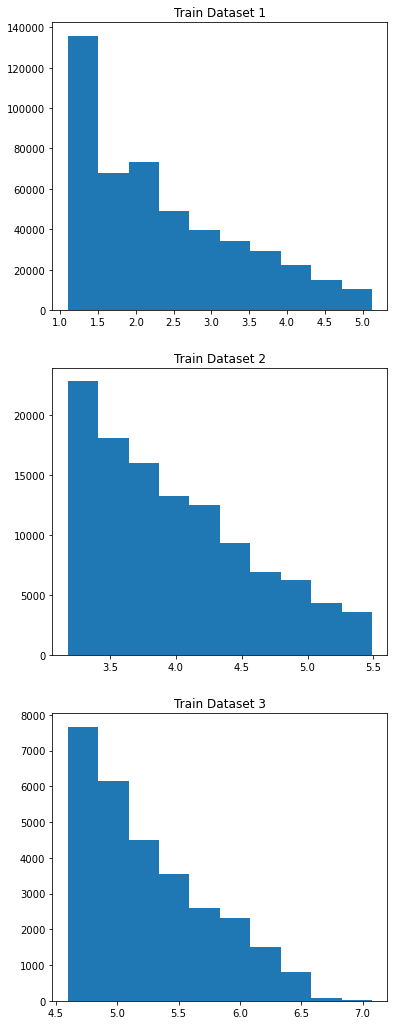

In [13]:
# 데이터의 왜도를 줄이기 위해 각 train dataset의 target에 로그 함수를 취해준다.

trn_1['hold_d'] = trn_1['hold_d'].apply(np.log1p)
trn_2['hold_d'] = trn_2['hold_d'].apply(np.log1p)
trn_3['hold_d'] = trn_3['hold_d'].apply(np.log1p)

# 로그 함수를 취해준 뒤 결과값 확인.
plt.figure(figsize=(6,18))

plt.subplot(3, 1, 1)                # trn_1
plt.hist(trn_1.hold_d)
plt.title('Train Dataset 1')

plt.subplot(3, 1, 2)                # trn_2
plt.hist(trn_2.hold_d)
plt.title('Train Dataset 2')

plt.subplot(3, 1, 3)                # trn_3
plt.hist(trn_3.hold_d)
plt.title('Train Dataset 3')

plt.show()

In [14]:
#########################################################################################
#########################################################################################
#########################################################################################

In [15]:
# 모델링은 GPU 사용을 위해 구글 코랩 환경에서 이용하였고, Feature Engineering 완료된 train dataset들을 보내줌.
# 구글 코랩으로 csv파일을 보내고 받는 과정과 모델링 과정은 모두 주석 처리하였음.

# trn_1.to_csv("trn_1.csv", index = False)
# tst_1.to_csv("tst_1.csv", index = False)
# trn_2.to_csv("trn_2.csv", index = False)
# tst_2.to_csv("tst_2.csv", index = False)
# trn_3.to_csv("trn_3.csv", index = False)
# tst_3.to_csv("tst_3.csv", index = False)

- in Google Colab

In [16]:
# # 경로 설정
# from google.colab import drive

# drive.mount('./drive')

In [17]:
# DATA_PATH = "/content/drive/MyDrive/dacon/NH/data"
# SUBMIT_PATH = "/content/drive/MyDrive/dacon/NH/submission"

# trn_1 = pd.read_csv(DATA_PATH + '/trn_1.csv')
# tst_1 = pd.read_csv(DATA_PATH + '/tst_1.csv')

# trn_2 = pd.read_csv(DATA_PATH + '/trn_2.csv')
# tst_2 = pd.read_csv(DATA_PATH + '/tst_2.csv')

# trn_3 = pd.read_csv(DATA_PATH + '/trn_3.csv')
# tst_3 = pd.read_csv(DATA_PATH + '/tst_3.csv')

# trn_1_label = trn_1['hold_d']
# trn_1 = trn_1.drop(['hold_d'],axis=1)
# tst_1 = tst_1.drop(['hold_d','hist_d','submit_id'],axis=1)

# trn_2_label = trn_2['hold_d']
# trn_2 = trn_2.drop(['hold_d'],axis=1)
# tst_2 = tst_2.drop(['hold_d','hist_d','submit_id'],axis=1)

# trn_3_label = trn_3['hold_d']
# trn_3 = trn_3.drop(['hold_d'],axis=1)
# tst_3 = tst_3.drop(['hold_d','hist_d','submit_id'],axis=1)

# tst_1.columns = trn_1.columns
# tst_2.columns = trn_2.columns
# tst_3.columns = trn_3.columns

### Modeling

catboost

In [18]:
def model_catboost(X_trn, y_trn, X_val, y_val, tst):
  model_catboost = CatBoostRegressor(iterations=2400,
                                   learning_rate=0.01,
                                   depth=6,
                                   eval_metric='RMSE',
                                   random_seed = 42,
                                   bagging_temperature=0.2,
                                   od_type='Iter',
                                   metric_period=50,
                                   od_wait=20,
                                   task_type="GPU"
                                   )

  model_catboost.fit(X_trn, y_trn,
                    eval_set=(X_val, y_val),
                    use_best_model=True,
                    verbose=50
                    )
  predict = model_catboost.predict(tst)
  return predict

xgboost

In [19]:
def model_xgboost(X_trn, y_trn, X_val, y_val, tst):
    params = {
          'objective': 'reg:squarederror', 
          'eval_metric': 'rmse',
          'eta': 0.001,
          'max_depth': 10, 
          'subsample': 0.6, 
          'colsample_bytree': 0.6,
          'alpha':0.001,
          'random_state': 42
          
    }

    training_data = xgb.DMatrix(X_trn, y_trn)
    validation_data = xgb.DMatrix(X_val, y_val)

    watchlist = [(training_data, 'train'), (validation_data, 'valid')]

    model_xgb = xgb.train(params, training_data, 2400, watchlist, maximize=False, early_stopping_rounds=100, verbose_eval=100 )

    data_test = xgb.DMatrix(tst)
    predict_test_xgb = model_xgb.predict(data_test, ntree_limit=model_xgb.best_ntree_limit )

    return predict_test_xgb

Get the predicted value from the models.

In [20]:
# X_trn_1, X_val_1, y_trn_1, y_val_1 = train_test_split(trn_1, trn_1_label, test_size=0.2, random_state=42)

# X_trn_2, X_val_2, y_trn_2, y_val_2 = train_test_split(trn_2, trn_2_label, test_size=0.2, random_state=42)

# X_trn_3, X_val_3, y_trn_3, y_val_3 = train_test_split(trn_3, trn_3_label, test_size=0.2, random_state=42)

# cat_predict_1 = model_catboost(X_trn_1, y_trn_1, X_val_1, y_val_1, tst_1)

# cat_predict_2 = model_catboost(X_trn_2, y_trn_2, X_val_2, y_val_2, tst_2)

# cat_predict_3 = model_catboost(X_trn_3, y_trn_3, X_val_3, y_val_3, tst_3)

# xgb_predict_1 = model_xgboost(X_trn_1, y_trn_1, X_val_1, y_val_1, tst_1)

# xgb_predict_2 = model_xgboost(X_trn_2, y_trn_2, X_val_2, y_val_2, tst_2)

# xgb_predict_3 = model_xgboost(X_trn_3, y_trn_3, X_val_3, y_val_3, tst_3)

In [21]:
# 구글 코랩에서 학습된 데이터 주피터 노트북으로 불러오기.


# CatBoost
cat_predict_1 = data_dir / 'submissiontst_1_submit.csv'
cat_predict_2 = data_dir / 'submissiontst_2_submit.csv'
cat_predict_3 = data_dir / 'submissiontst_3_submit.csv'

cat_predict1 = pd.read_csv(cat_predict_1)
cat_predict2 = pd.read_csv(cat_predict_2)
cat_predict3 = pd.read_csv(cat_predict_3)

cat_predict1 = np.array(cat_predict1)
cat_predict2 = np.array(cat_predict2)
cat_predict3 = np.array(cat_predict3)


# XGBoost
xgb_predict_1 = data_dir / 'submissionxgb_tst_1.csv'
xgb_predict_2 = data_dir / 'submissionxgb_tst_2.csv'
xgb_predict_3 = data_dir / 'submissionxgb_tst_3.csv'


xgb_predict1 = pd.read_csv(xgb_predict_1)
xgb_predict2 = pd.read_csv(xgb_predict_2)
xgb_predict3 = pd.read_csv(xgb_predict_3)

xgb_predict1 = np.array(xgb_predict1)
xgb_predict2 = np.array(xgb_predict2)
xgb_predict3 = np.array(xgb_predict3)

In [22]:
#########################################################################################
#########################################################################################
#########################################################################################

<h3>Post Processing

In [23]:
def post_processing(predict1, predict2, predict3, tst_1, tst_2, tst_3):
    # rescaling predict result

    s_1 = MinMaxScaler(feature_range=(10,120))
    s_2 = MinMaxScaler(feature_range=(50,120))
    s_3 = MinMaxScaler(feature_range=(70,140))

    scaled_predict1 = s_1.fit_transform(predict1)
    scaled_predict2 = s_2.fit_transform(predict2)
    scaled_predict3 = s_3.fit_transform(predict3)

    scaled_predict1 = np.ceil(scaled_predict1)
    scaled_predict2 = np.ceil(scaled_predict2)
    scaled_predict3 = np.ceil(scaled_predict3)
    
    sub_1 = tst_1[['submit_id']]
    sub_1['predict_1'] = scaled_predict1

    sub_2 = tst_2[['submit_id']]
    sub_2['predict_2'] = scaled_predict2

    sub_3 = tst_3[['submit_id']]
    sub_3['predict_3'] = scaled_predict3

    sub_ = pd.concat([sub_1,sub_2,sub_3])
    sub_ = sub_.sort_values(by=['submit_id'])
    sub_ = sub_.fillna(0)

    return (sub_['predict_1'] + sub_['predict_2'] + sub_['predict_3'])

In [24]:
xgb_predict = post_processing(xgb_predict1, xgb_predict2, xgb_predict3, tst_1, tst_2, tst_3)

In [25]:
cat_predict = post_processing(cat_predict1, cat_predict2, cat_predict3, tst_1, tst_2, tst_3)

<h3>Ensemble

In [26]:
predict_hold_d = np.ceil(0.5*cat_predict + 0.5*xgb_predict)
predict_hold_d.index = sub.index

<h3>Submission

In [27]:
sub['hold_d'] = tst['hist_d'] + predict_hold_d

In [28]:
sub.to_csv("ensemble_model_.csv", index = False)